In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sklearn
from sklearn.linear_model import LinearRegression
from copy import deepcopy
import polars as pl
from jax import numpy as jnp
from jax import grad, jit, vmap

In [520]:
# !wget https://gitlab.com/evgeny.zavalnyuk/sirius_ml_labs/-/raw/main/ps3/mldata.csv
mldata_path='mldata.csv'
ml_data = pd.read_csv(mldata_path, index_col=0)
ml_data.index = pd.to_datetime(ml_data['date'])
ml_data = ml_data.drop(columns=['date']).sort_index()

In [113]:
ml_data_target_mask = ml_data.columns[-4:]
ml_data_train_mask = ml_data.columns[1:-4]

#### LASSO REGRESSION

In [100]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [101]:
X_jnp = np.asarray(ml_data[ml_data_train_mask])
Y_jnp = np.asarray(ml_data[ml_data_target_mask[0]])

In [285]:
X_jnp.shape

(283380, 93)

In [102]:
%%time
alpha = 1e-5
lasso_regressor = Lasso(alpha=alpha)

lasso_regressor.fit(ml_data[ml_data_train_mask], ml_data[ml_data_target_mask[0]])

CPU times: user 2min 40s, sys: 3min 38s, total: 6min 18s
Wall time: 5.72 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.212e+01, tolerance: 8.966e-01
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1e-05)

In [122]:
%%time
alpha = 1e-3
ridge_regressor = Ridge(alpha=alpha)

ridge_regressor.fit(ml_data[ml_data_train_mask], ml_data[ml_data_target_mask[0]])

CPU times: user 367 ms, sys: 308 ms, total: 675 ms
Wall time: 464 ms


Ridge(alpha=0.001)

In [126]:
res = pd.Series(ridge_regressor.coef_, index=ml_data_train_mask).sort_values()
cut_level = 10
cutted_res = pd.concat([res[:cut_level], res[-cut_level:]])

In [124]:
res = pd.Series(lasso_regressor.coef_, index=ml_data_train_mask).sort_values()
cut_level = 10
cutted_res = pd.concat([res[:cut_level], res[-cut_level:]])

<BarContainer object of 20 artists>

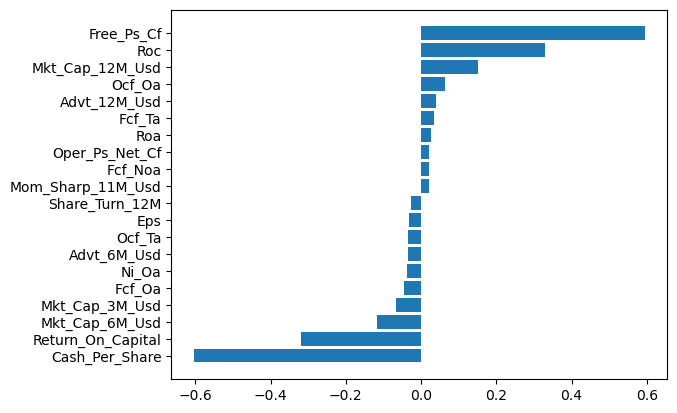

In [127]:
plt.barh(cutted_res.index, cutted_res.values)

In [ ]:
%%time
alphas = np.logspace(-6, -2, 50)

lasso_coeffs = {} #np.zeros((alphas.shape[0], len(ml_data_train_mask)))

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(ml_data[ml_data_train_mask], ml_data[ml_data_target_mask[0]])
    lasso_coeffs[alpha] = lasso.coef_

In [60]:
lasso_results = pd.DataFrame(data=lasso_coeffs.values(), columns=ml_data_train_mask, index=lasso_coeffs.keys())

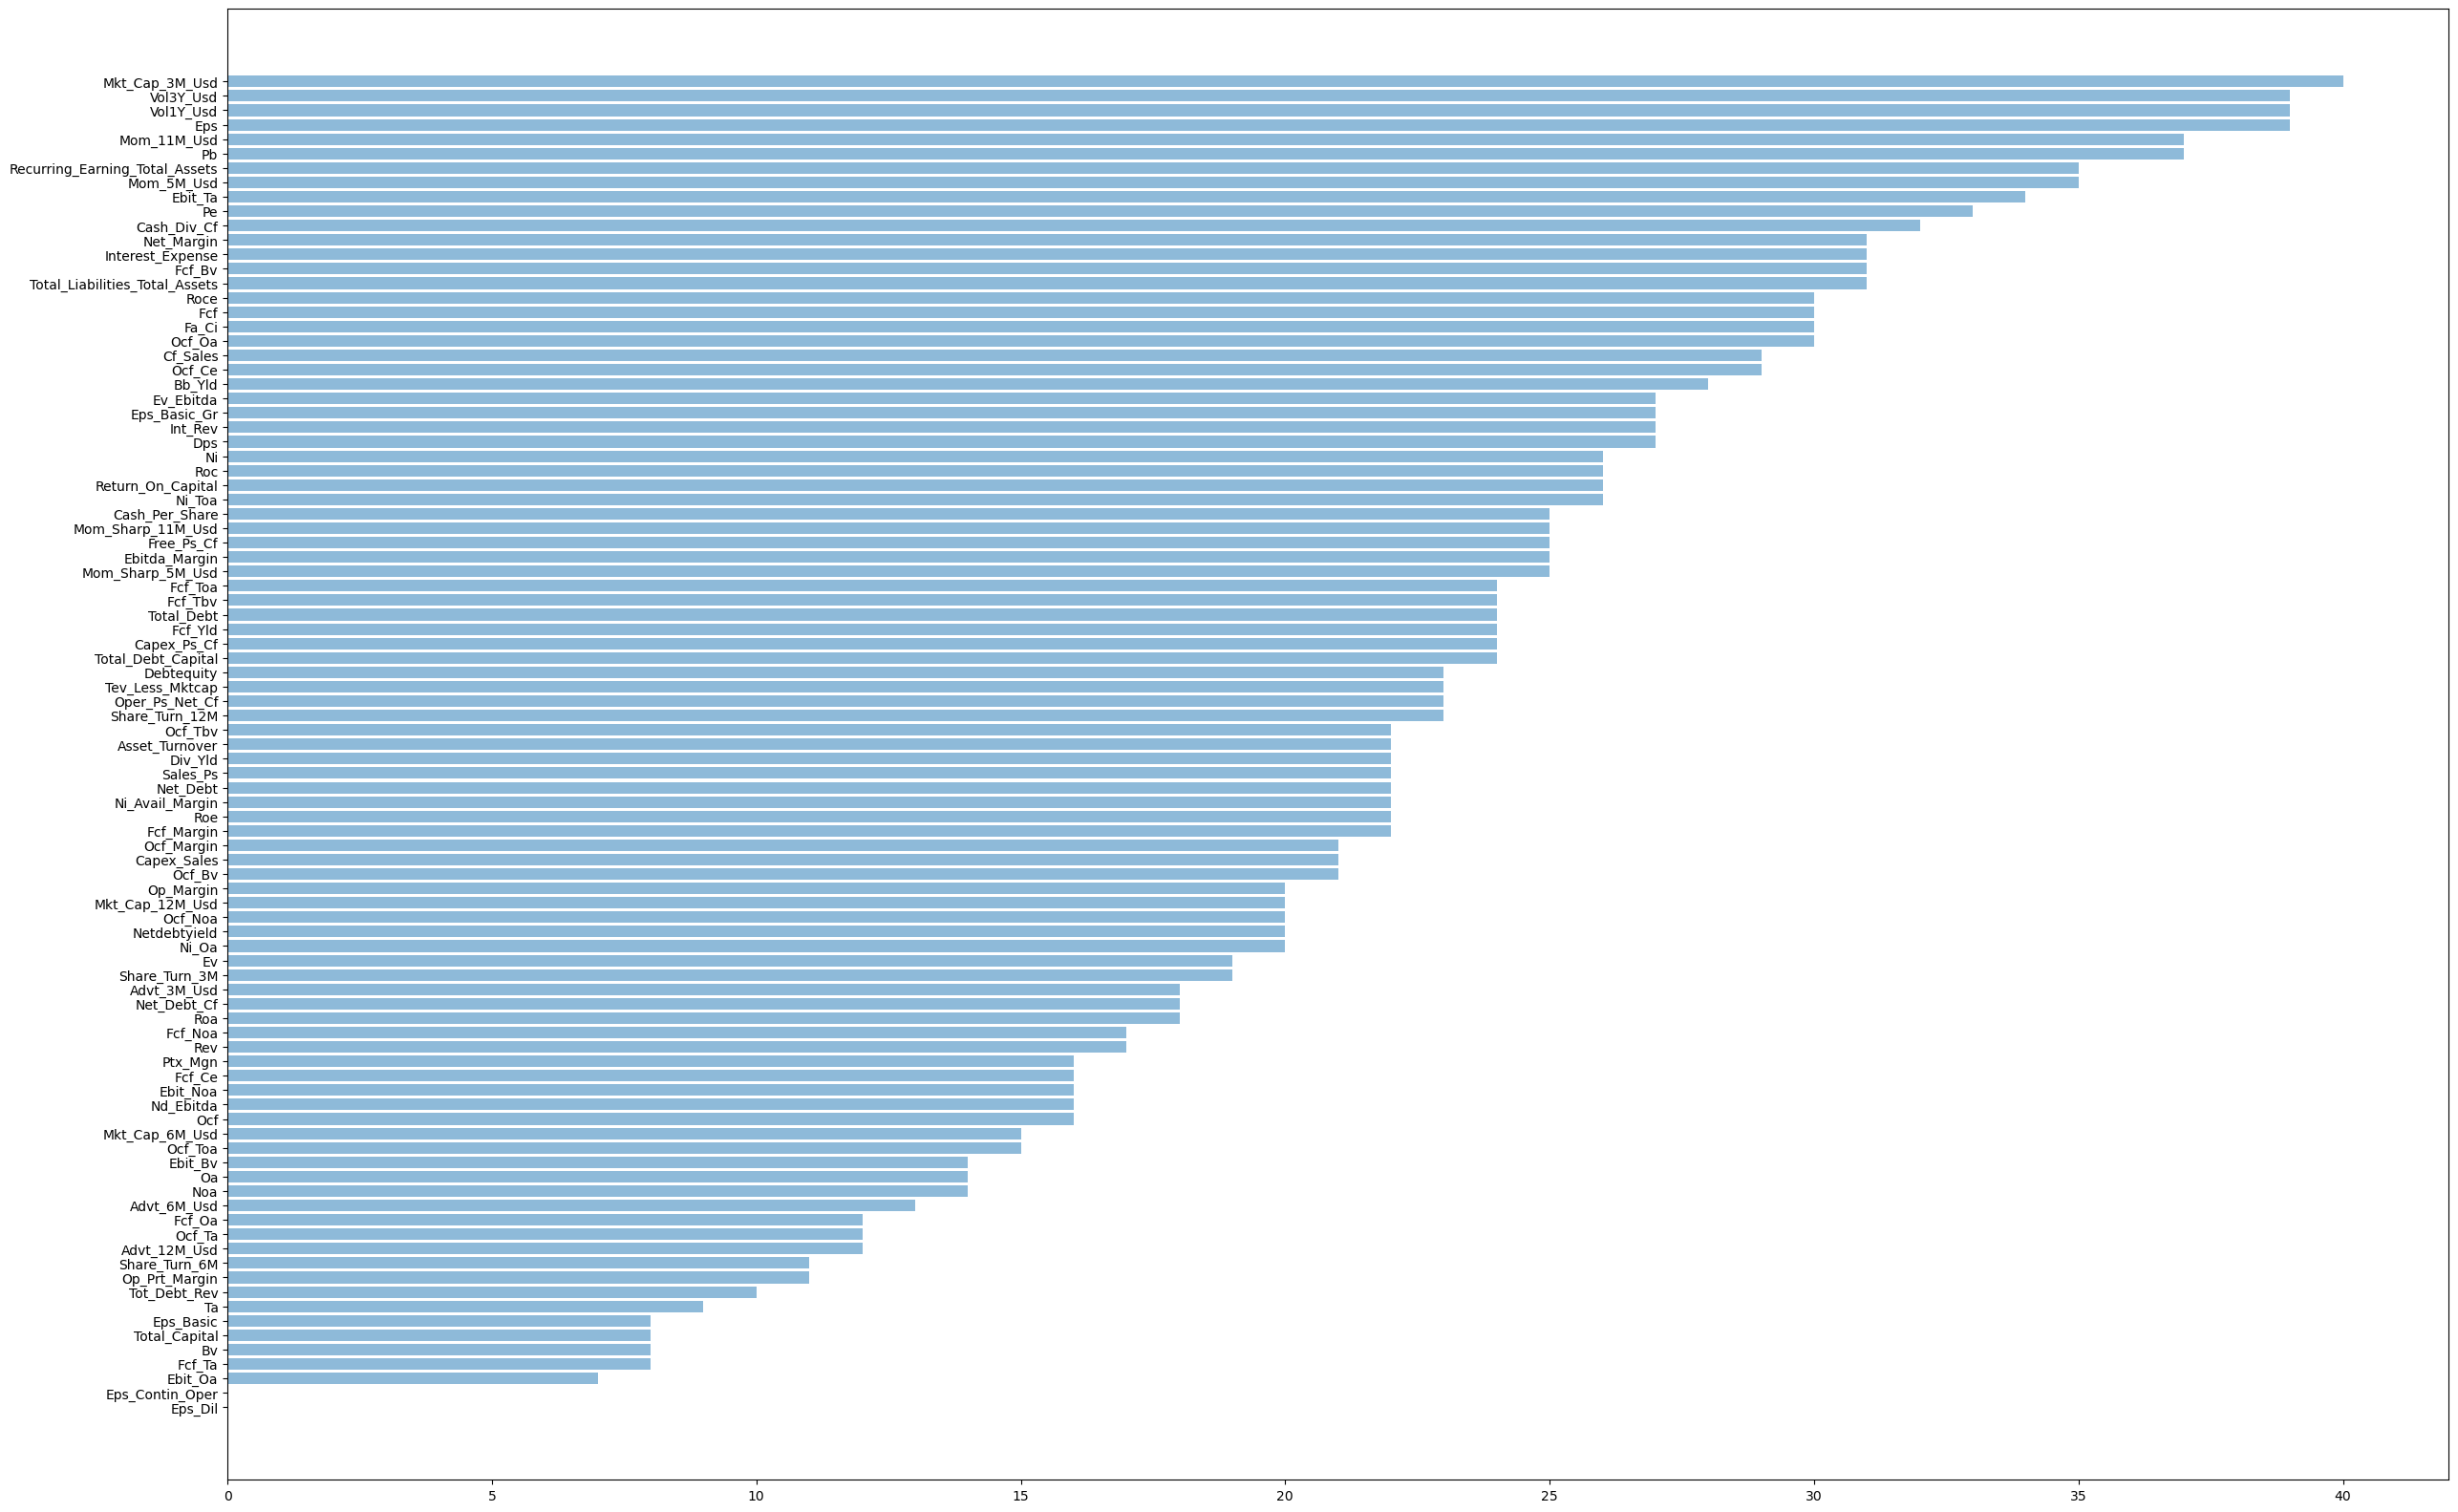

In [63]:
plt.figure(figsize=(30, 20))
_ = plt.barh(
    lasso_results[lasso_results != 0].count(axis=0).sort_values().index, 
    lasso_results[lasso_results != 0].count(axis=0).sort_values(),
    alpha=0.5
)

In [242]:
# most viable 10 features (treat as the best)
lasso_results[lasso_results != 0].count(axis=0).sort_values()[:-10:-1]

Mkt_Cap_3M_Usd                    40
Vol3Y_Usd                         39
Vol1Y_Usd                         39
Eps                               39
Mom_11M_Usd                       37
Pb                                37
Recurring_Earning_Total_Assets    35
Mom_5M_Usd                        35
Ebit_Ta                           34
dtype: int64

[]

<Figure size 2000x1000 with 0 Axes>

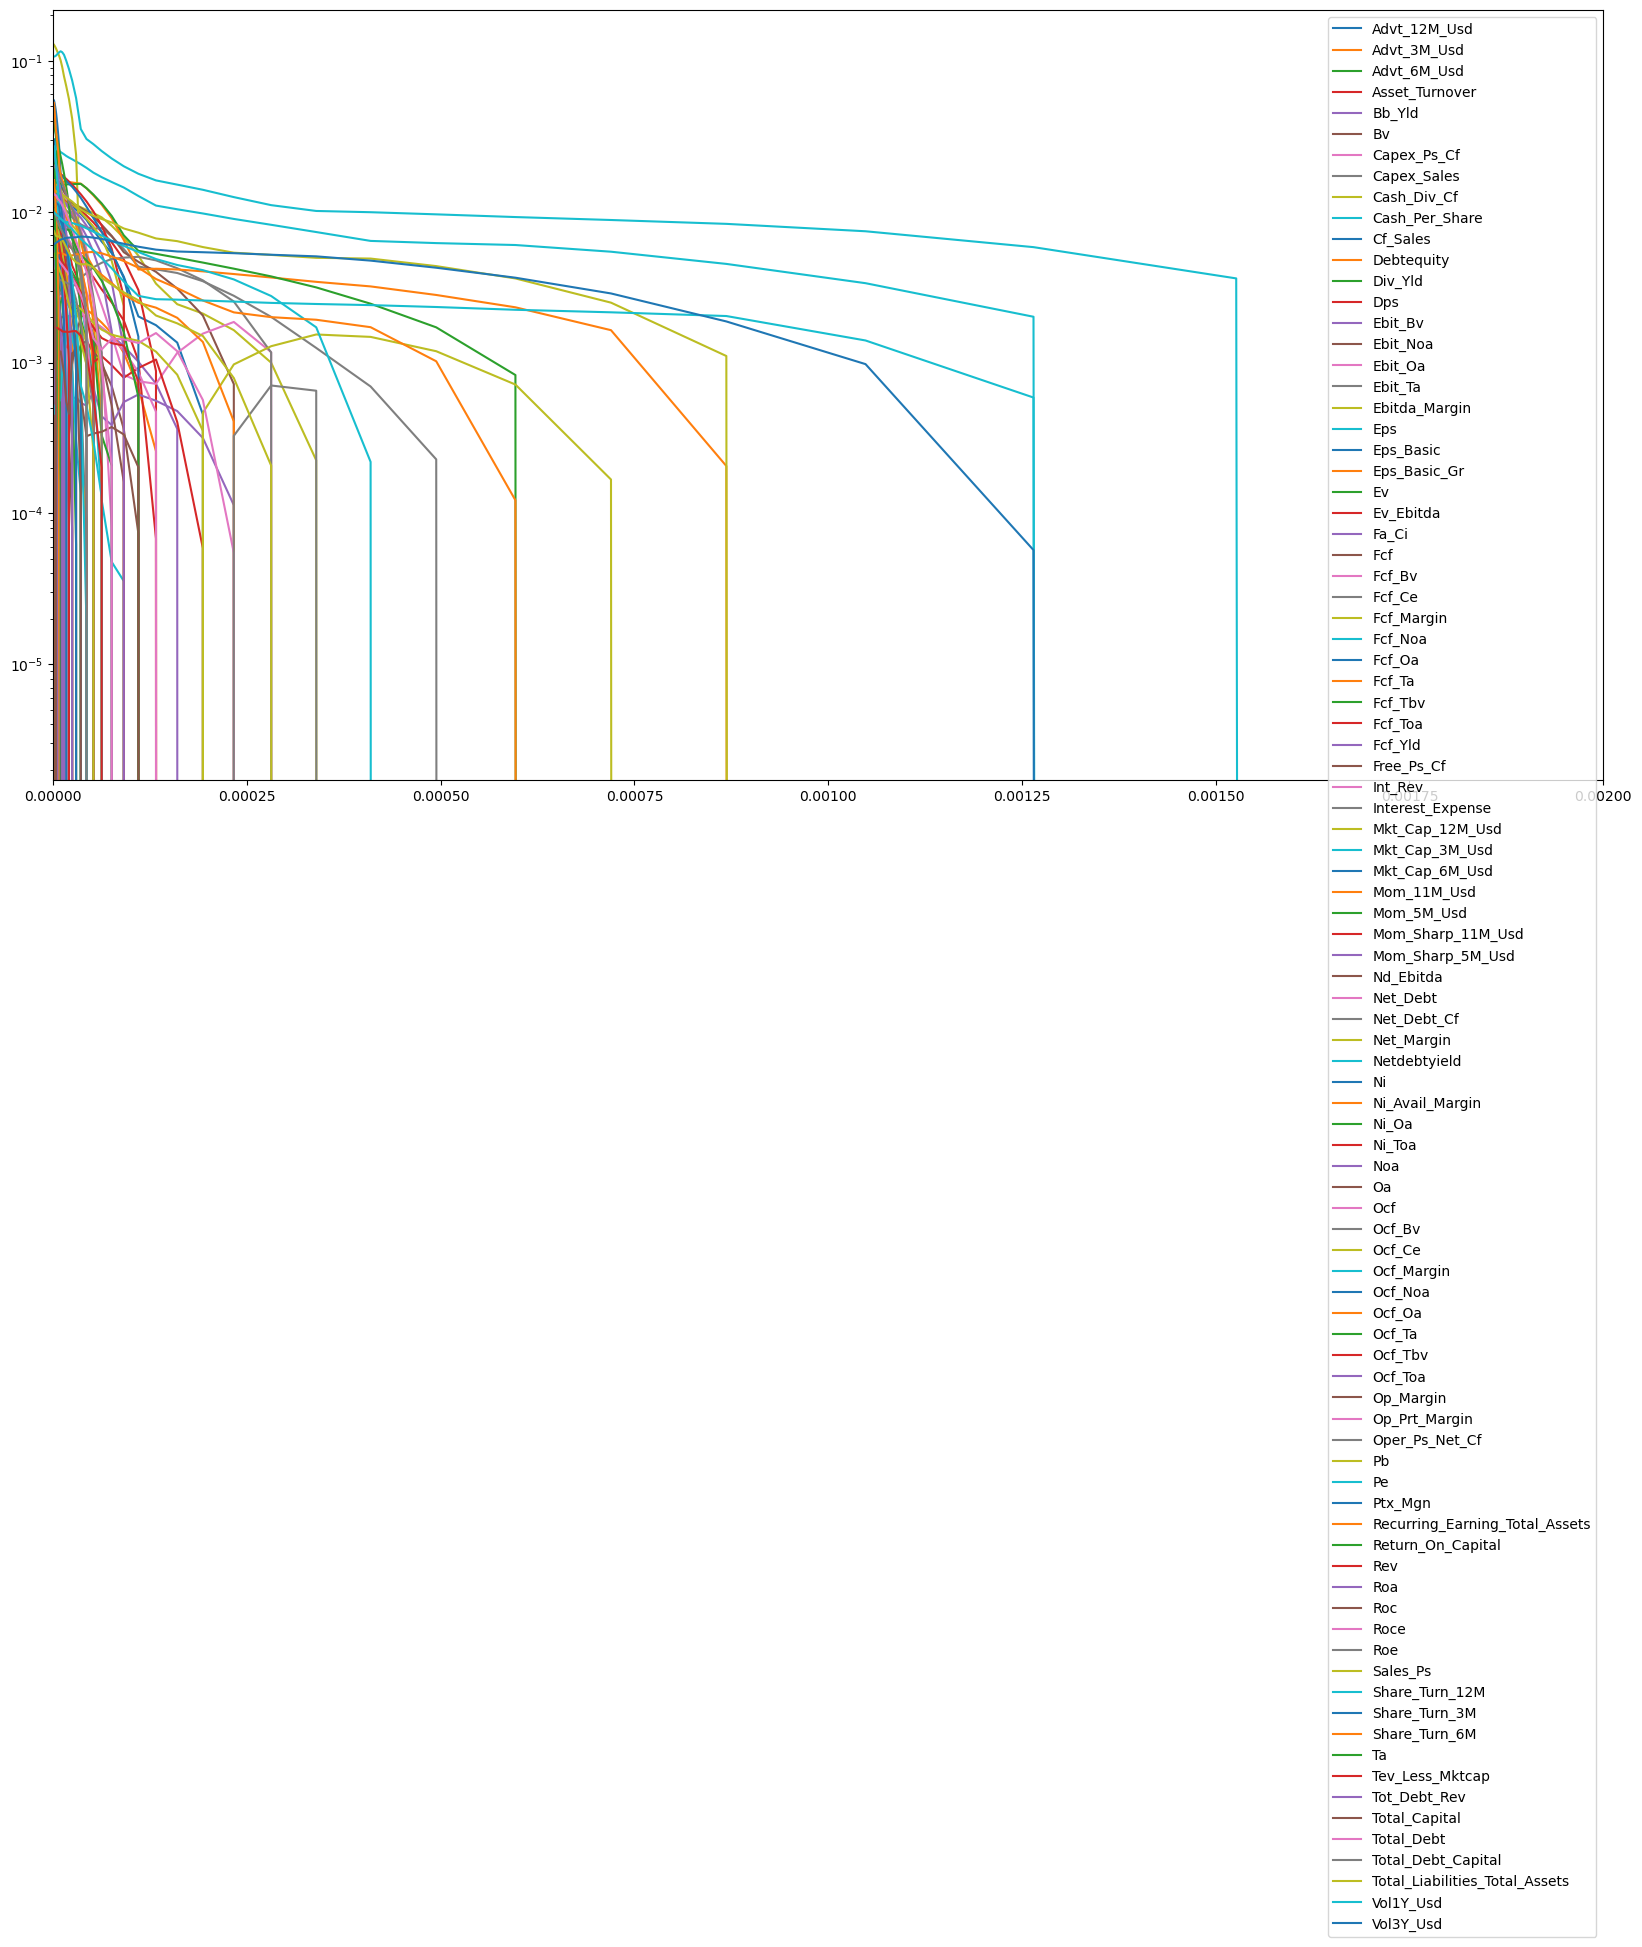

In [77]:
plt.figure(figsize=(20, 10))
lasso_results.iloc[:].loc[:,lasso_results.iloc[:].abs().sum(axis=0)>0].abs().plot(figsize=(20, 10))
plt.xlim(0, 0.002)
plt.semilogy(base=10)

#### MEAN DECREASE ANALYSIS

In [279]:
# create train, validation, test
train_mask = [pd.to_datetime('2015-01-01'), pd.to_datetime('2018-01-01')]
validation_mask = [pd.to_datetime('2018-01-01'), pd.to_datetime('2019-01-01')]
test_mask = [pd.to_datetime('2019-01-01'), pd.to_datetime('2020-01-01')]

# masks
ml_data_target_mask = ml_data.columns[-4:]
ml_data_train_mask = ml_data.columns[1:-4]

In [170]:
# create models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV

lin_reg = LinearRegression()  # basic OLS model
lasso   = Lasso(alpha=1e-4)   # with L1 regularization with alpha coeff
ridge   = Ridge(alpha=1e-2)   # with L2 reg with alpha coeff
elastic = ElasticNetCV()      # combination of L1 & L2 regularizations

In [ ]:
%%time

# fit the models
lin_reg.fit(ml_data.loc[train_mask[0]:train_mask[1], ml_data_train_mask], ml_data.loc[train_mask[0]:train_mask[1], ml_data_target_mask[0]])
lasso.fit(ml_data.loc[train_mask[0]:train_mask[1], ml_data_train_mask], ml_data.loc[train_mask[0]:train_mask[1], ml_data_target_mask[0]])
ridge.fit(ml_data.loc[train_mask[0]:train_mask[1], ml_data_train_mask], ml_data.loc[train_mask[0]:train_mask[1], ml_data_target_mask[0]])
elastic.fit(ml_data.loc[train_mask[0]:train_mask[1], ml_data_train_mask], ml_data.loc[train_mask[0]:train_mask[1], ml_data_target_mask[0]])

In [243]:
%%time

from copy import deepcopy

iterations = 20 # how much statistics we collect

feature_model_performance = {}

# translate df to numpy
X_train = np.asarray( ml_data.loc[train_mask[0]:train_mask[1], ml_data_train_mask] )
Y_train = np.asarray( ml_data.loc[train_mask[0]:train_mask[1], ml_data_target_mask[0]] )

X_validation = np.asarray( ml_data.loc[validation_mask[0]:validation_mask[1], ml_data_train_mask] )
Y_validation = np.asarray( ml_data.loc[validation_mask[0]:validation_mask[1], ml_data_target_mask[0]] )

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
baseline_score = lin_reg.score(X_validation, Y_validation)

# start MDA
for pos, feature in enumerate(ml_data_train_mask):
    statistics = []
    for iteration in range(iterations):
        X_corrupted = deepcopy(X_train)
        X_corrupted[:, pos] = np.random.permutation( X_corrupted[:, pos] ) # shuffle data
            
        lin_reg = LinearRegression()
        lin_reg.fit(X_corrupted, Y_train)
        statistics.append(baseline_score - lin_reg.score(X_validation, Y_validation))
        # print(f'{feature}, R2 = {statistics[-1]}, coef = {lin_reg.coef_[pos]}')
    statistics = np.asarray(statistics)
    feature_model_performance[feature] = statistics

CPU times: user 52min 11s, sys: 3h 36min 37s, total: 4h 28min 48s
Wall time: 4min 20s


In [251]:
bx = pd.Series(feature_model_performance)
bx = bx[bx.apply(lambda x : x.mean()).sort_values().index]
print('Most 10 important by simple MDA:\n')
print(list(bx.index[:-11:-1]))

Most 10 important by simple MDA:

['Cash_Div_Cf', 'Ocf_Ta', 'Ocf_Oa', 'Ocf_Ce', 'Dps', 'Ni', 'Ocf_Margin', 'Capex_Sales', 'Fcf_Ce', 'Fcf']


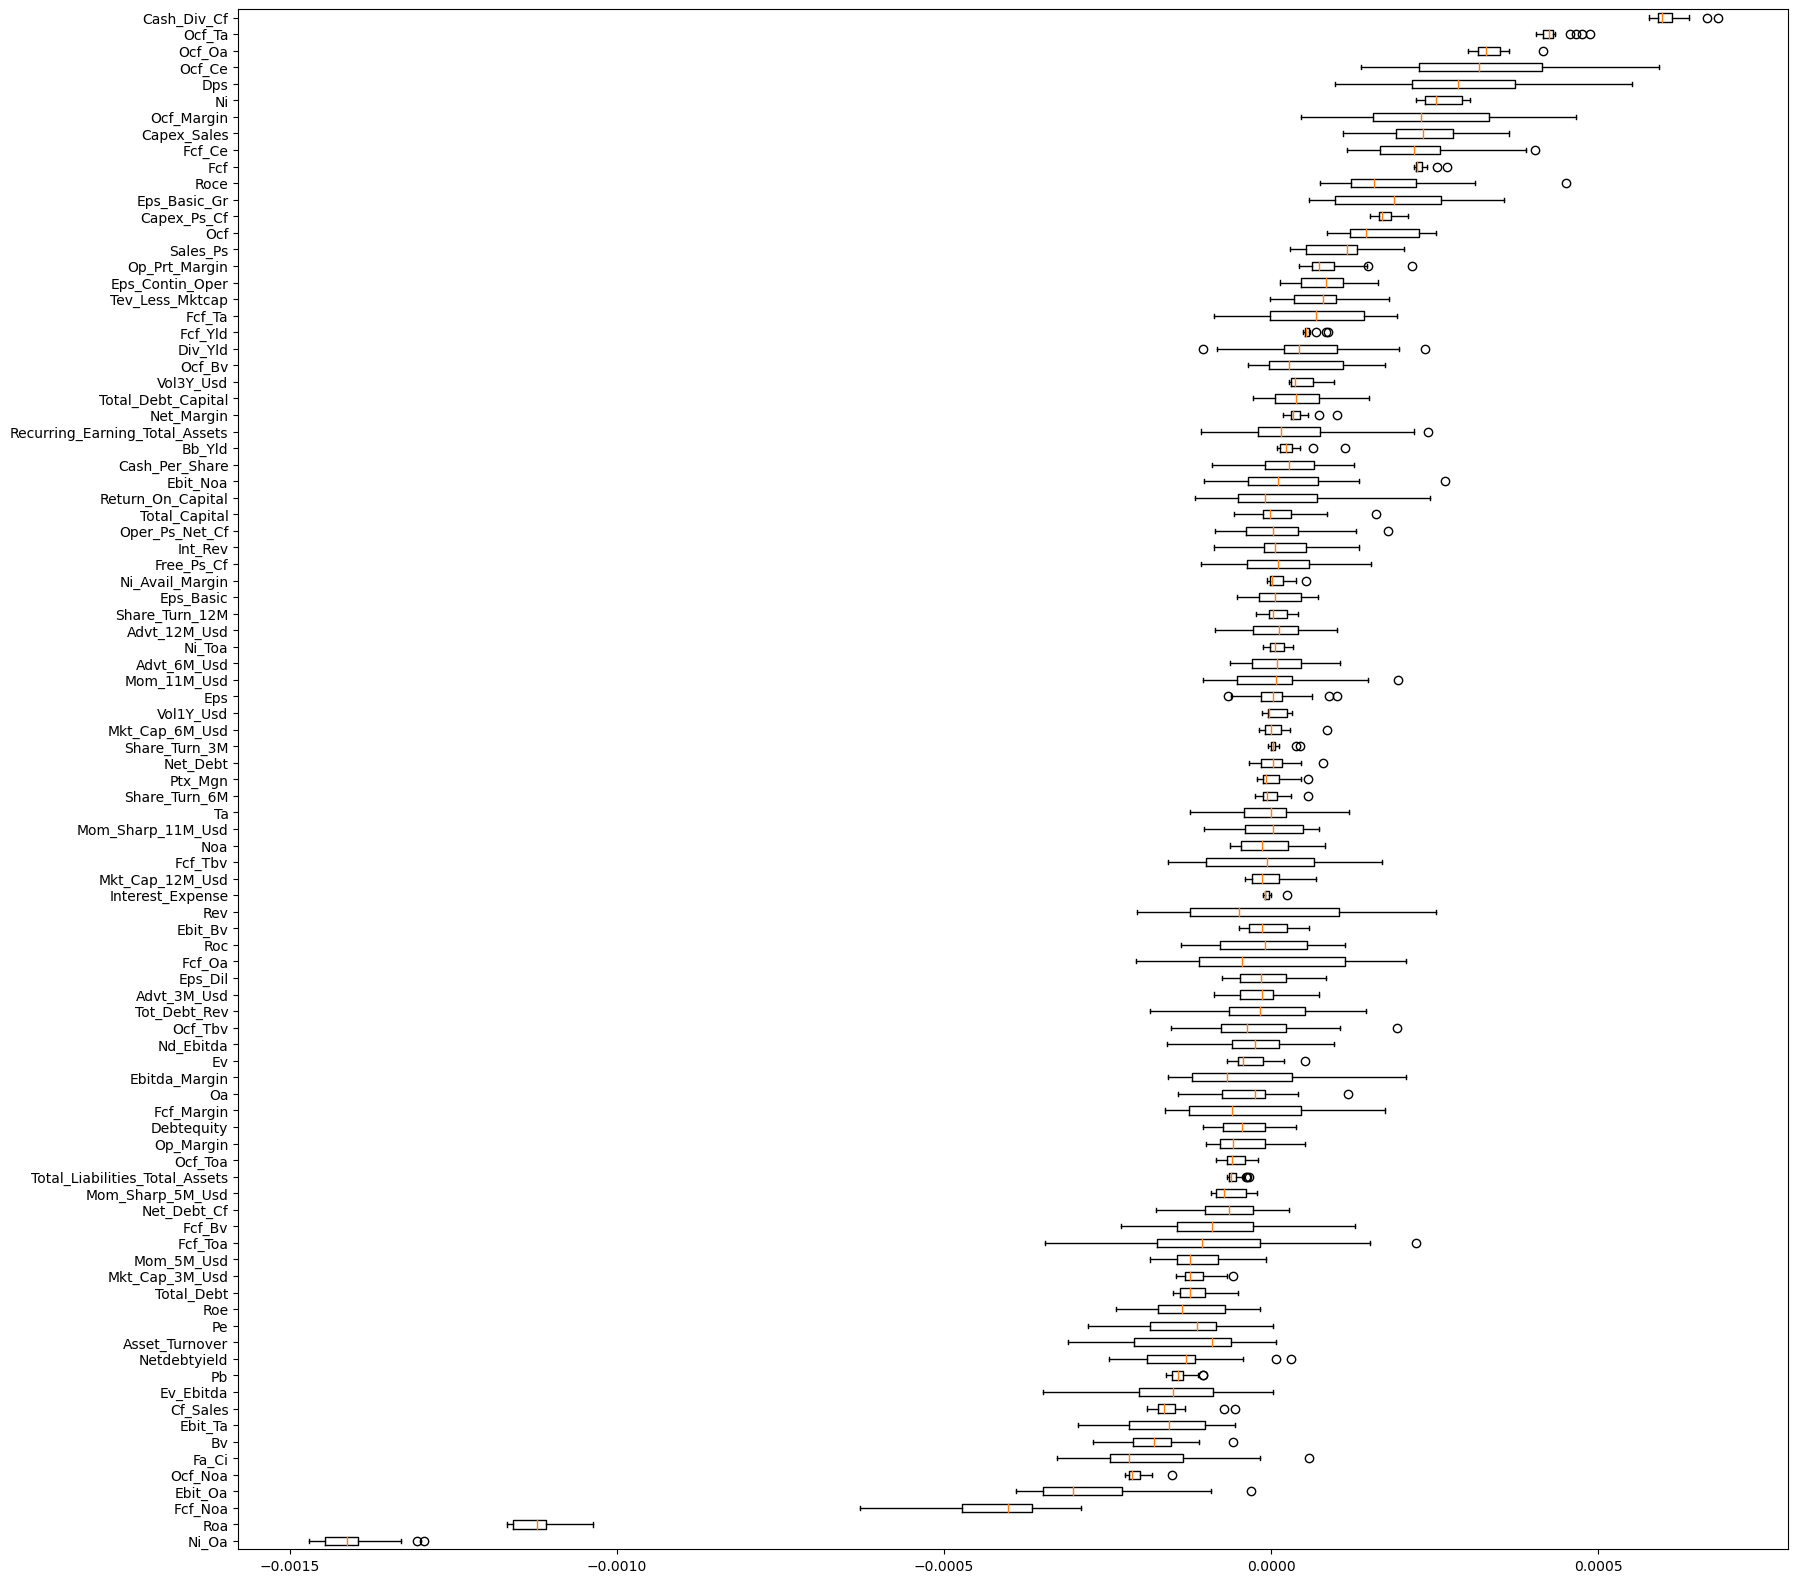

In [245]:
plt.figure(figsize=(20,20))
_ = plt.boxplot(bx, vert=False, autorange=True, labels=bx.index)

#### CLUSTERED MDA

In [276]:
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import ward_tree, AgglomerativeClustering
from scipy.spatial.distance import pdist

In [358]:
%%time

# create clustering and fit clusters
clustering = AgglomerativeClustering(n_clusters=4, compute_distances=True, memory='cache')
clustering.fit(X_train.T)
clusters = clustering.labels_

CPU times: user 107 ms, sys: 0 ns, total: 107 ms
Wall time: 105 ms


In [376]:
# make the dictionary contains labelling
cluster_labels = {i : [] for i in range(clustering.n_clusters)}
for i, feature in enumerate(ml_data_train_mask):
    cluster_labels[clusters[i]].append(feature)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


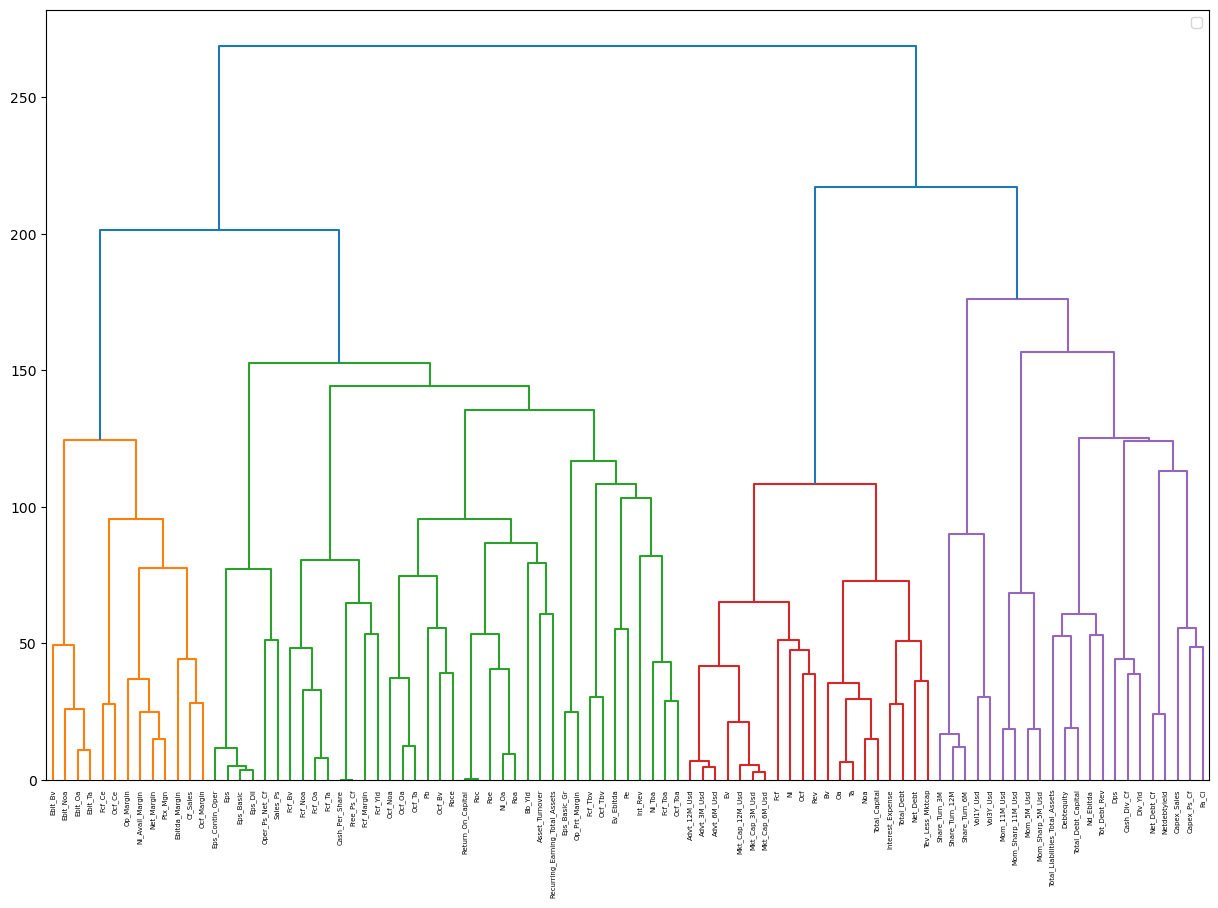

CPU times: user 896 ms, sys: 176 ms, total: 1.07 s
Wall time: 854 ms


{0: ['Capex_Ps_Cf',
  'Capex_Sales',
  'Cash_Div_Cf',
  'Debtequity',
  'Div_Yld',
  'Dps',
  'Fa_Ci',
  'Mom_11M_Usd',
  'Mom_5M_Usd',
  'Mom_Sharp_11M_Usd',
  'Mom_Sharp_5M_Usd',
  'Nd_Ebitda',
  'Net_Debt_Cf',
  'Netdebtyield',
  'Share_Turn_12M',
  'Share_Turn_3M',
  'Share_Turn_6M',
  'Tot_Debt_Rev',
  'Total_Debt_Capital',
  'Total_Liabilities_Total_Assets',
  'Vol1Y_Usd',
  'Vol3Y_Usd'],
 1: ['Asset_Turnover',
  'Bb_Yld',
  'Cash_Per_Share',
  'Eps',
  'Eps_Basic',
  'Eps_Basic_Gr',
  'Eps_Contin_Oper',
  'Eps_Dil',
  'Ev_Ebitda',
  'Fcf_Bv',
  'Fcf_Margin',
  'Fcf_Noa',
  'Fcf_Oa',
  'Fcf_Ta',
  'Fcf_Tbv',
  'Fcf_Toa',
  'Fcf_Yld',
  'Free_Ps_Cf',
  'Int_Rev',
  'Ni_Oa',
  'Ni_Toa',
  'Ocf_Bv',
  'Ocf_Noa',
  'Ocf_Oa',
  'Ocf_Ta',
  'Ocf_Tbv',
  'Ocf_Toa',
  'Op_Prt_Margin',
  'Oper_Ps_Net_Cf',
  'Pb',
  'Pe',
  'Recurring_Earning_Total_Assets',
  'Return_On_Capital',
  'Roa',
  'Roc',
  'Roce',
  'Roe',
  'Sales_Ps'],
 2: ['Advt_12M_Usd',
  'Advt_3M_Usd',
  'Advt_6M_Usd',
  'B

In [408]:
%%time

# visualize
y = pdist(X_train.T)
tree_hierarchy = hierarchy.ward(y)
plt.figure(figsize=(15,10))
drd = dendrogram(tree_hierarchy, p=4, labels=ml_data_train_mask)
_ = plt.xticks(rotation='vertical')
plt.legend()
plt.show()
cluster_labels

In [443]:
%%time

from copy import deepcopy

iterations = 50 # how much statistics we collect

feature_model_performance = {}

# translate df to numpy
X_train = np.asarray( ml_data.loc[train_mask[0]:train_mask[1], ml_data_train_mask] )
Y_train = np.asarray( ml_data.loc[train_mask[0]:train_mask[1], ml_data_target_mask[0]] )

X_validation = np.asarray( ml_data.loc[validation_mask[0]:validation_mask[1], ml_data_train_mask] )
Y_validation = np.asarray( ml_data.loc[validation_mask[0]:validation_mask[1], ml_data_target_mask[0]] )

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
baseline_score = lin_reg.score(X_validation, Y_validation)

# perform CLUSTERED MDA
for i, (cluster, features) in enumerate(cluster_labels.items()):
    statistics = []
    X_corrupted = ml_data.loc[train_mask[0]:train_mask[1], ml_data_train_mask]
    for iteration in range(iterations):
        for feature in features: 
            X_corrupted[feature] = np.random.permutation( X_corrupted[feature] ) # shuffle data
            
        lin_reg = LinearRegression()
        lin_reg.fit(np.asarray(X_corrupted), Y_train)
        statistics.append(baseline_score - lin_reg.score(X_validation, Y_validation))
    statistics = np.asarray(statistics)
    feature_model_performance[cluster] = statistics

CPU times: user 5min 38s, sys: 23min 18s, total: 28min 57s
Wall time: 30.6 s


In [444]:
bx = pd.Series(feature_model_performance)
bx = bx[bx.apply(lambda x : x.mean()).sort_values().index]
print('Ranked MDA clusters by importance:\n')
print(list(bx.index))

Ranked MDA clusters by importance:

[1, 3, 2, 0]


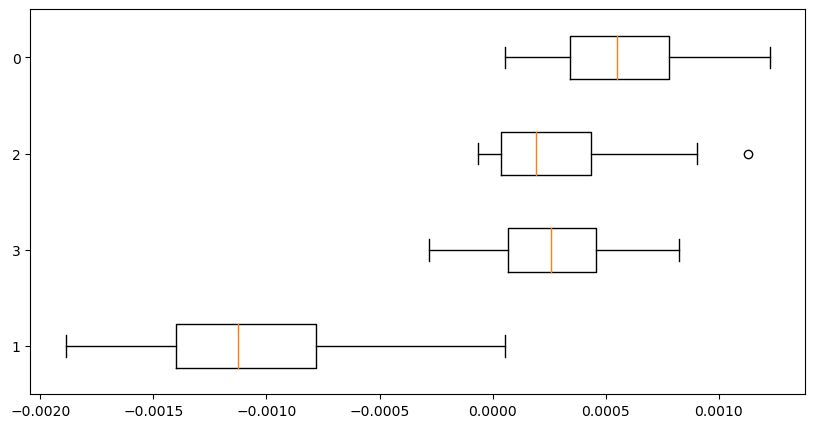

In [447]:
plt.figure(figsize=(10,5))
_ = plt.boxplot(bx, vert=False, autorange=True, labels=bx.index)

In [462]:
# backtest results

X_train = np.asarray( ml_data.loc[train_mask[0]:train_mask[1], ml_data_train_mask] )
Y_train = np.asarray( ml_data.loc[train_mask[0]:train_mask[1], ml_data_target_mask[0]] )

X_test = np.asarray( ml_data.loc[test_mask[0]:test_mask[1], ml_data_train_mask] )
Y_test = np.asarray( ml_data.loc[test_mask[0]:test_mask[1], ml_data_target_mask[0]] )

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

print(f'Linreg on train R2 = {lin_reg.score(X_train, Y_train)}')
print(f'Linreg on test  R2 = {lin_reg.score(X_test, Y_test)}\n')

alpha = 1e-3
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, Y_train)

print(f'Lasso on train R2 = {lasso.score(X_train, Y_train)}')
print(f'Lasso on test  R2 = {lasso.score(X_test, Y_test)}\n')

# drop undesirable cluster

# compose desirable features
desirable_features = []
for cluster, features in cluster_labels.items():
    if cluster != 1:
        #print(cluster, features)
        for feature in features:
            desirable_features.append(feature)
            
X_train = np.asarray( ml_data.loc[train_mask[0]:train_mask[1], desirable_features] )
Y_train = np.asarray( ml_data.loc[train_mask[0]:train_mask[1], ml_data_target_mask[0]] )

X_test = np.asarray( ml_data.loc[test_mask[0]:test_mask[1], desirable_features] )
Y_test = np.asarray( ml_data.loc[test_mask[0]:test_mask[1], ml_data_target_mask[0]] )

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

print(f'Linreg on train R2 (dropped cluster) = {lin_reg.score(X_train, Y_train)}')
print(f'Linreg on test  R2 (dropped cluster) = {lin_reg.score(X_test, Y_test)}\n')

alpha = 1e-3
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, Y_train)

print(f'Lasso on train R2 (dropped cluster) = {lasso.score(X_train, Y_train)}')
print(f'Lasso on test  R2 (dropped cluster) = {lasso.score(X_test, Y_test)}\n')


Linreg on train R2 = 0.008571470995686337
Linreg on test  R2 = -0.0006433841071622481

Lasso on train R2 = 0.00019401344001224174
Lasso on test  R2 = -0.005010892380119758

Linreg on train R2 (dropped cluster) = 0.0035360123411892763
Linreg on test  R2 (dropped cluster) = -0.003407414199447345

Lasso on train R2 (dropped cluster) = 0.00019401344001224174
Lasso on test  R2 (dropped cluster) = -0.005010892380119758



SHORT LIST OF CLUSTERED MDA ANALYSIS:
1. DROPPING THE WORST CLUSTER DIDN'T IMPROVE THE MODEL QUALITY
2. LASSO DROPPED THE UNCONSISTENT FEAUTRES SO THAT IN BOTH CASES THE PERFORMANCE DIDN'T CHANGE

#### CORRELATION CHECKING

In [468]:
correlation_matrix = {}

for i, (cluster, features) in enumerate(cluster_labels.items()):
    correlation_matrix[cluster] = ml_data.loc[train_mask[0]:train_mask[1], features].corr()

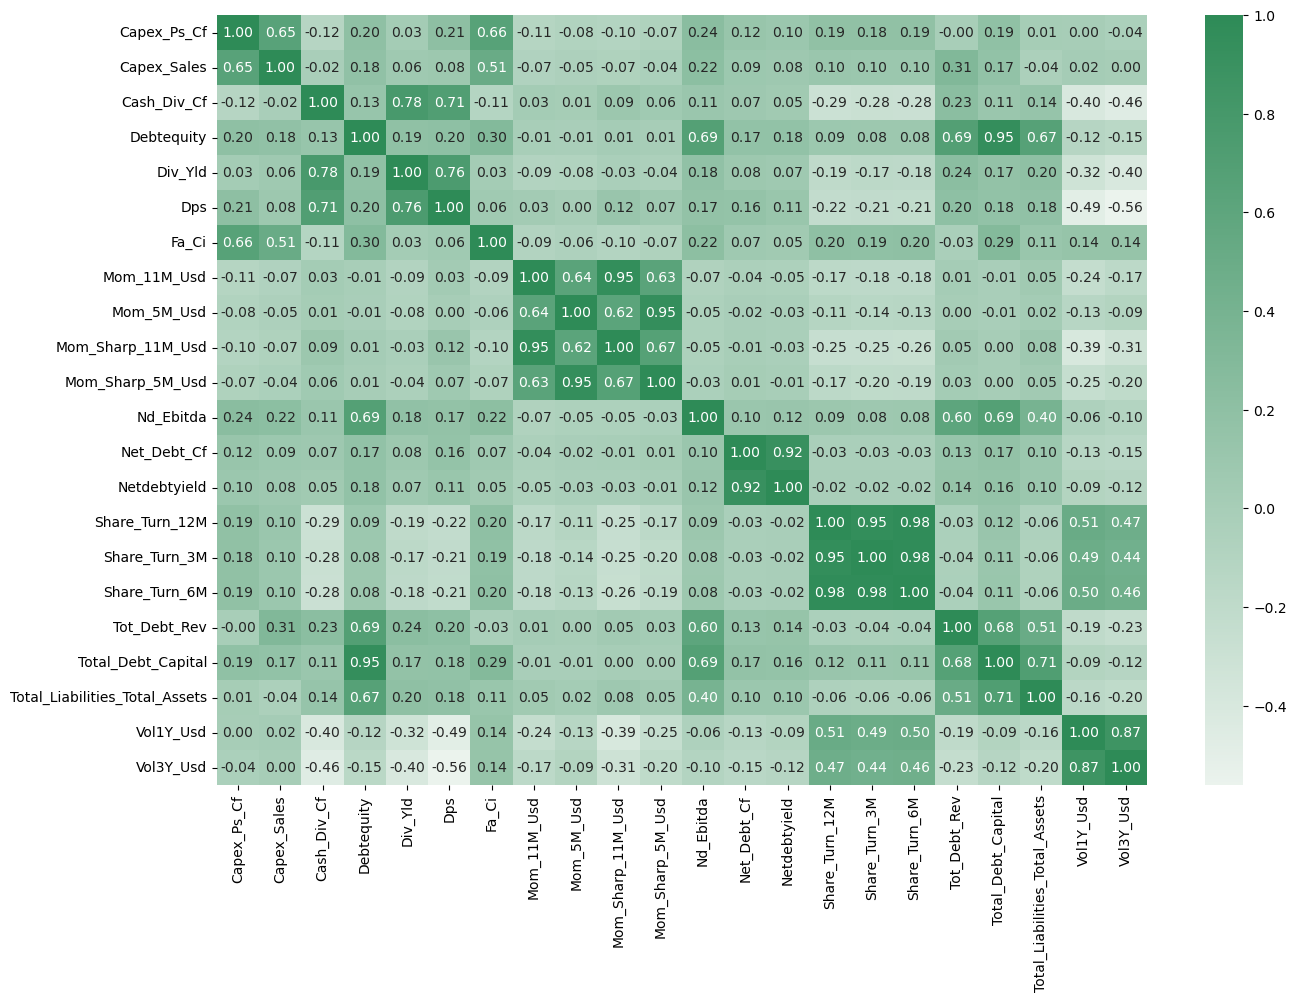

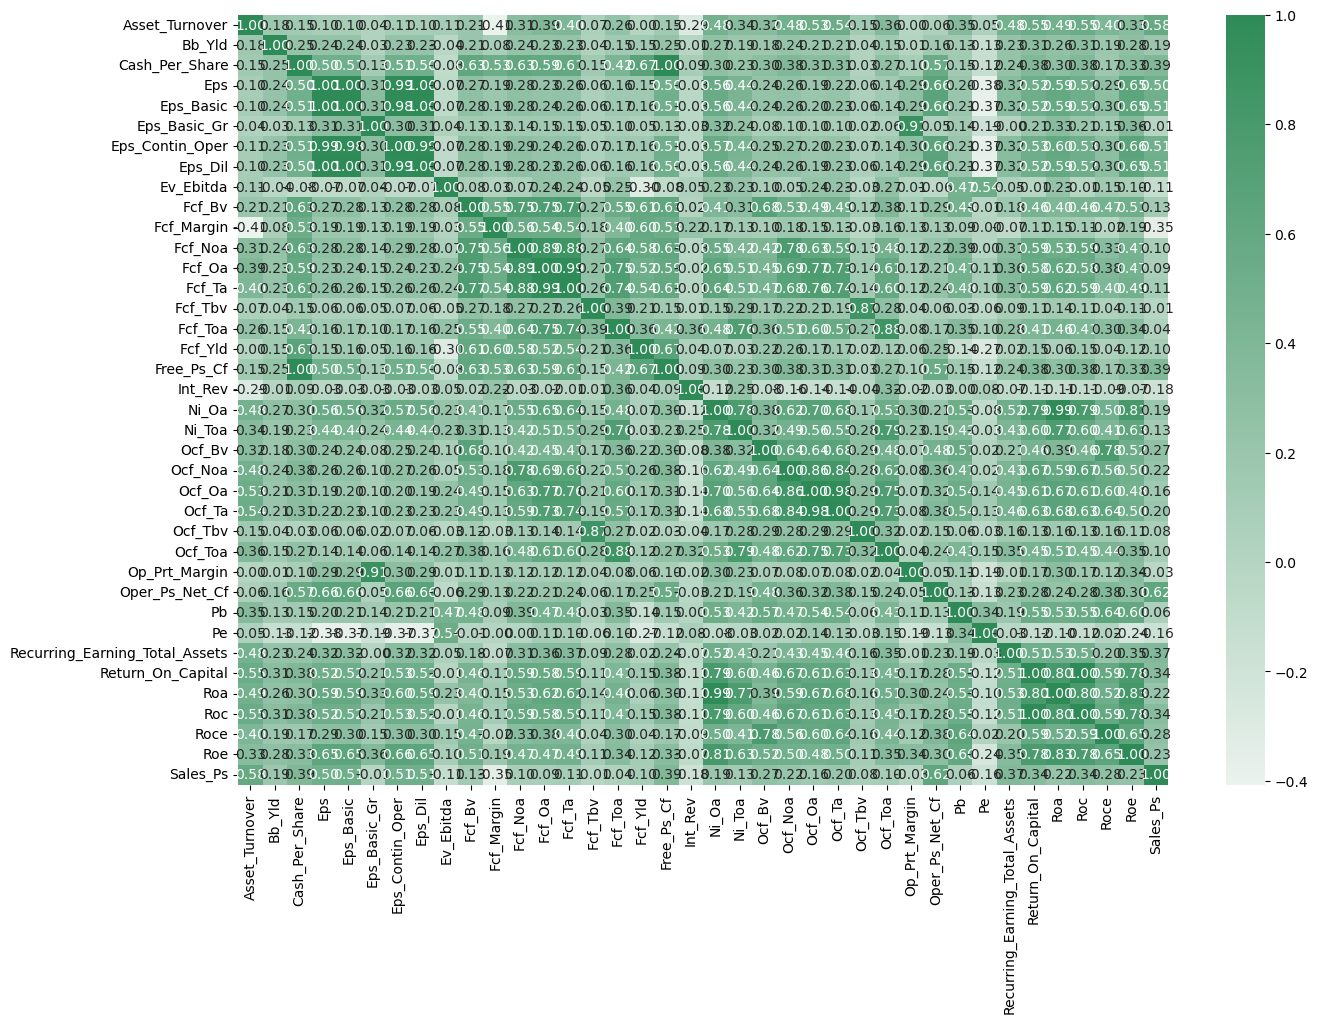

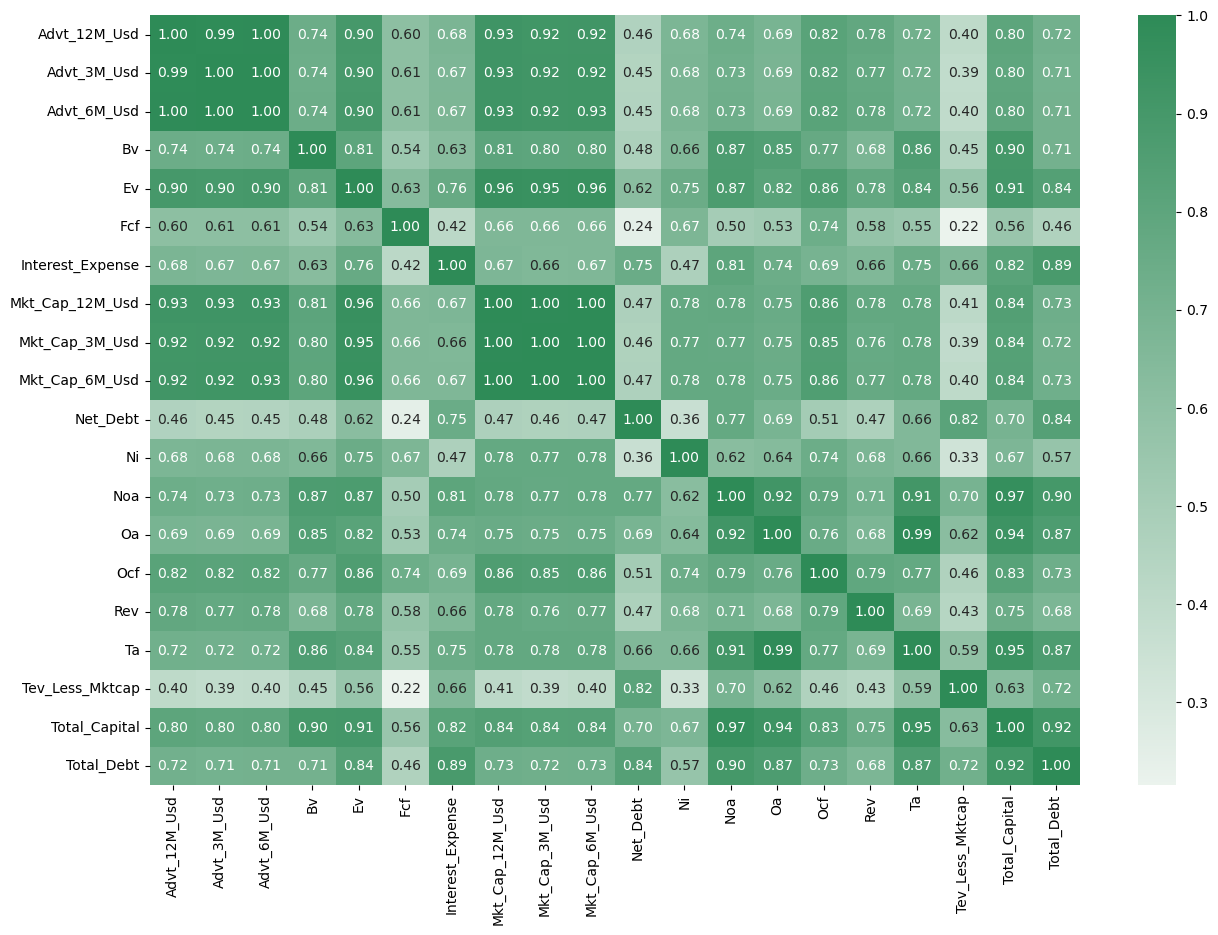

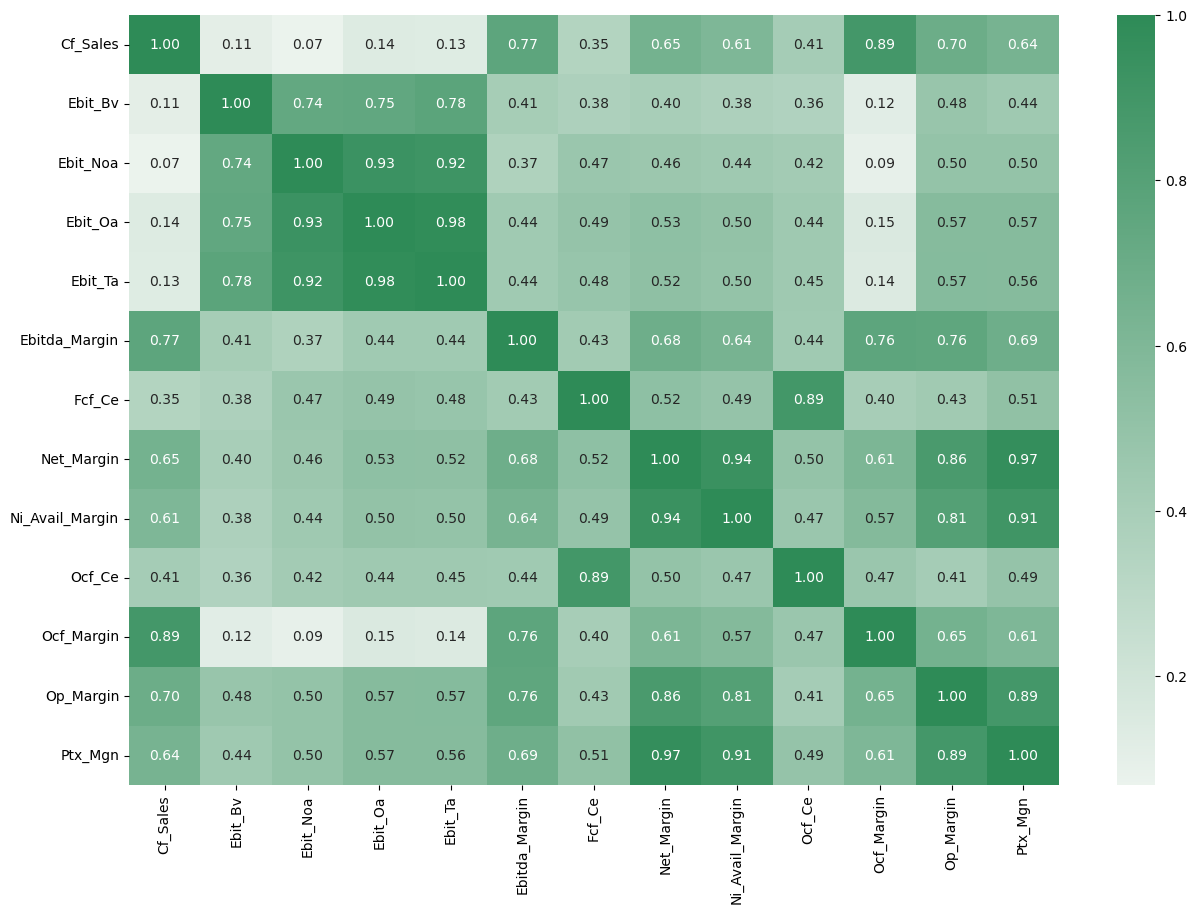

In [477]:
import seaborn as sns

cmap_1 = sns.light_palette("seagreen", as_cmap=True)

for i, (cluster, features) in enumerate(cluster_labels.items()):
    plt.figure(i, figsize=(15, 10))
    sns.heatmap(correlation_matrix[cluster], cmap=cmap_1, annot=True, fmt=".2f")
    plt.show()

In [501]:
cluster_corr_sum = {}
cluster_corr_q = {}
features_to_delete = {}

for i, (cluster, features) in enumerate(cluster_labels.items()):
    cluster_corr_sum[cluster] = []
    features_to_delete[cluster] = []
    for feature in features:
        cluster_corr_sum[cluster].append(correlation_matrix[cluster][feature].abs().sum() - 1)
    
    cluster_corr_q[cluster] = np.quantile(np.asarray(cluster_corr_sum[cluster]), 0.75)
    
    for i, feature in enumerate(features):
        if cluster_corr_sum[cluster][i] > cluster_corr_q[cluster]:
            features_to_delete[cluster].append(features[i])

list_features_to_delete = []
for i, (cluster, features) in enumerate(cluster_labels.items()):
    for feature in features_to_delete[cluster]:
        list_features_to_delete.append(feature)

In [502]:
X_train = np.asarray( ml_data.loc[train_mask[0]:train_mask[1], ml_data_train_mask].drop(columns=list_features_to_delete) )
Y_train = np.asarray( ml_data.loc[train_mask[0]:train_mask[1], ml_data_target_mask[0]] )

X_test = np.asarray( ml_data.loc[test_mask[0]:test_mask[1], ml_data_train_mask].drop(columns=list_features_to_delete) )
Y_test = np.asarray( ml_data.loc[test_mask[0]:test_mask[1], ml_data_target_mask[0]] )

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

print(f'Linreg on train R2 = {lin_reg.score(X_train, Y_train)}')
print(f'Linreg on test  R2 = {lin_reg.score(X_test, Y_test)}\n')

alpha = 1e-3
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, Y_train)

print(f'Lasso on train R2 = {lasso.score(X_train, Y_train)}')
print(f'Lasso on test  R2 = {lasso.score(X_test, Y_test)}\n')

Linreg on train R2 = 0.003443526500837235
Linreg on test  R2 = -0.001982263882013058

Lasso on train R2 = 7.223672290057603e-05
Lasso on test  R2 = -0.00505662881746094



EXTRA SHORT LIST:
1. DROPPING HIGH CORRELATED FEATURES DIDN'T IMPROVE THE QUALITY OF THE MODELS

#### SIMPLE PORTFOLIO MANAGEMENT BASED ON LINEAR REGRESSION

In [503]:
# MAKE THE SIMPLEST APPROACH - FIT THE LINEAR REGRESSION ON N PREVIOUS OBSERVATIONS AND GET POSITION OF ASSET AS A RETURN PREDICTION

In [522]:
# create train, validation, test
train_mask = [pd.to_datetime('2015-01-01'), pd.to_datetime('2020-01-01')]
# validation_mask = [pd.to_datetime('2018-01-01'), pd.to_datetime('2019-01-01')]
# test_mask = [pd.to_datetime('2019-01-01'), pd.to_datetime('2020-01-01')]

# masks
ml_data_target_mask = ml_data.columns[-4:]
ml_data_train_mask = ml_data.columns[:-4]

In [599]:
control_dates = ml_data.loc[train_mask[0]:train_mask[1]].index.unique()
portfolio_weights = {}

available_stocks_on_date = {}
for date in control_dates:
    available_stocks_on_date[date] = ml_data.loc[date, 'stock_id'].unique()
    portfolio_weights[date] = {stock_id : 0 for stock_id in sorted(ml_data['stock_id'].unique())}

In [612]:
lfd = deepcopy(list_features_to_delete[:-3])

N_bias = 10
for i, date in enumerate(control_dates[N_bias:-1]):
    lin_reg = LinearRegression()
    lin_reg.fit(
        ml_data.loc[control_dates[i]:date, ml_data_train_mask].drop(columns=lfd), 
        ml_data.loc[control_dates[i]:date, ml_data_target_mask[0]]) 
    print(f'last train date = {date}, predict date = {control_dates[i+N_bias+1]}')
    for stock in available_stocks_on_date[date]:
        try:
            result = lin_reg.predict(
                ml_data.loc[control_dates[i+N_bias+1], ml_data_train_mask][ml_data.loc[control_dates[i+N_bias+1], 'stock_id']==stock].drop(columns=lfd)
            )
            portfolio_weights[date][stock] = result
        except:
            continue

last train date = 2015-11-30 00:00:00, predict date = 2015-12-31 00:00:00
last train date = 2015-12-31 00:00:00, predict date = 2016-01-31 00:00:00
last train date = 2016-01-31 00:00:00, predict date = 2016-02-29 00:00:00
last train date = 2016-02-29 00:00:00, predict date = 2016-03-31 00:00:00
last train date = 2016-03-31 00:00:00, predict date = 2016-04-30 00:00:00
last train date = 2016-04-30 00:00:00, predict date = 2016-05-31 00:00:00
last train date = 2016-05-31 00:00:00, predict date = 2016-06-30 00:00:00
last train date = 2016-06-30 00:00:00, predict date = 2016-07-31 00:00:00
last train date = 2016-07-31 00:00:00, predict date = 2016-08-31 00:00:00
last train date = 2016-08-31 00:00:00, predict date = 2016-09-30 00:00:00
last train date = 2016-09-30 00:00:00, predict date = 2016-10-31 00:00:00
last train date = 2016-10-31 00:00:00, predict date = 2016-11-30 00:00:00
last train date = 2016-11-30 00:00:00, predict date = 2016-12-31 00:00:00
last train date = 2016-12-31 00:00:00,

In [925]:
def renorm_portfolio(portfolio):
    new_portfolio = deepcopy(portfolio)
    new_portfolio = new_portfolio.sub(new_portfolio.mean(axis=1), 0)
    new_portfolio = new_portfolio.div(new_portfolio.abs().sum(1) + 1e-8, 0)
    return new_portfolio

def get_pnl(portfolio):
    pnl = portfolio.sum(axis=1)
    return pnl

In [759]:
new_portfolio_weights = {}
for date, stocks in portfolio_weights.items():
    new_portfolio_weights[date] = {}
    for stock in stocks:
        if type(portfolio_weights[date][stock]) == type(np.array([2])):
            new_portfolio_weights[date][stock] = portfolio_weights[date][stock][0]
        else:
            new_portfolio_weights[date][stock] = portfolio_weights[date][stock]

In [934]:
portfolio_df = pd.DataFrame(new_portfolio_weights).T.loc[control_dates[N_bias:-1]] #[(portfolio_df.abs().sum() != 0) . index]
portfolio_df[portfolio_df==0] = None

In [935]:
norm_portfolio = renorm_portfolio(portfolio_df)

In [808]:
stocks_returns = {}
for date, stocks in new_portfolio_weights.items():
    stocks_returns[date] = {}
    print(date)
    for stock in stocks:
        temp = ml_data.loc[date, ['stock_id', 'R1M_Usd']]
        try:
            value = temp[temp['stock_id'] == stock]['R1M_Usd'].values[0]
            stocks_returns[date][stock] = value
        except:
            stocks_returns[date][stock] = None

2015-01-31 00:00:00
2015-02-28 00:00:00
2015-03-31 00:00:00
2015-04-30 00:00:00
2015-05-31 00:00:00
2015-06-30 00:00:00
2015-07-31 00:00:00
2015-08-31 00:00:00
2015-09-30 00:00:00
2015-10-31 00:00:00
2015-11-30 00:00:00
2015-12-31 00:00:00
2016-01-31 00:00:00
2016-02-29 00:00:00
2016-03-31 00:00:00
2016-04-30 00:00:00
2016-05-31 00:00:00
2016-06-30 00:00:00
2016-07-31 00:00:00
2016-08-31 00:00:00
2016-09-30 00:00:00
2016-10-31 00:00:00
2016-11-30 00:00:00
2016-12-31 00:00:00
2017-01-31 00:00:00
2017-02-28 00:00:00
2017-03-31 00:00:00
2017-04-30 00:00:00
2017-05-31 00:00:00
2017-06-30 00:00:00
2017-07-31 00:00:00
2017-08-31 00:00:00
2017-09-30 00:00:00
2017-10-31 00:00:00
2017-11-30 00:00:00
2017-12-31 00:00:00
2018-01-31 00:00:00
2018-02-28 00:00:00
2018-03-31 00:00:00
2018-04-30 00:00:00
2018-05-31 00:00:00
2018-06-30 00:00:00
2018-07-31 00:00:00
2018-08-31 00:00:00
2018-09-30 00:00:00
2018-10-31 00:00:00
2018-11-30 00:00:00
2018-12-31 00:00:00
2019-01-31 00:00:00
2019-02-28 00:00:00


In [812]:
stocks_returns_df = pd.DataFrame(stocks_returns).T

In [939]:
def construct_pnl(portfolio, returns):
    return (portfolio * returns.loc[portfolio.index]).sum(axis=1).cumsum()

def describe_sharpe(pnl):
    monthly_return = pnl.diff(1)
    sharpe = monthly_return.mean() / monthly_return.std() * np.sqrt(12)
    return sharpe

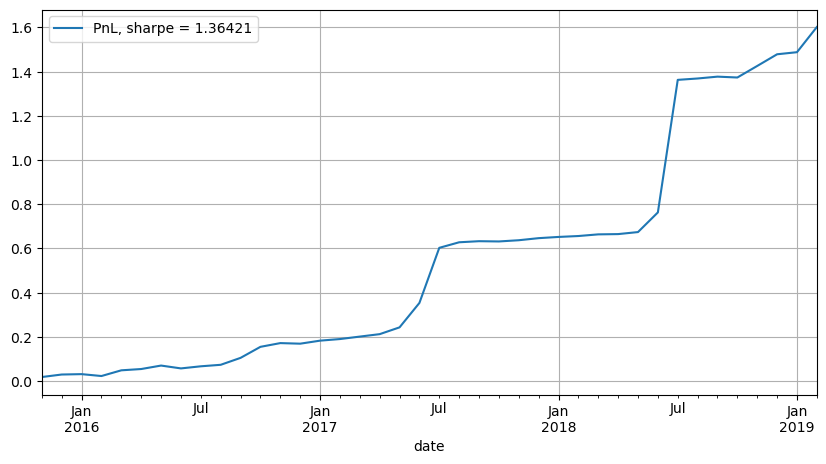

In [941]:
plt.figure(figsize=(10,5))
pnl = construct_pnl(norm_portfolio, stocks_returns_df)
pnl.plot(label=f'PnL, sharpe = {describe_sharpe(pnl):.5f}')
plt.legend()
plt.grid()
plt.show()

#### SHAPLEY VALUES ANALYSIS

In [8]:
import xgboost
import numpy as np
import shap

In [9]:
# simulate some binary data and a linear outcome with an interaction term
# note we make the features in X perfectly independent of each other to make
# it easy to solve for the exact SHAP values
N = 2000
X = np.zeros((N,5))
X[:1000,0] = 1
X[:500,1] = 1
X[1000:1500,1] = 1
X[:250,2] = 1
X[500:750,2] = 1
X[1000:1250,2] = 1
X[1500:1750,2] = 1
X[:,0:3] -= 0.5
y = 2*X[:,0] - 3*X[:,1]

In [10]:
# ensure the variables are independent
np.cov(X.T)


array([[0.25012506, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.25012506, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.25012506, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [13]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({
    'eta':1, 'max_depth':3, 'base_score': 0, "lambda": 0
}, Xd, 1)
print("Model error =", np.linalg.norm(y-model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

Model error = 0.0
0:[f1<0.5] yes=1,no=2,missing=2,gain=4500,cover=2000
	1:[f0<0.5] yes=3,no=4,missing=4,gain=1000,cover=1000
		3:leaf=0.5,cover=500
		4:leaf=2.5,cover=500
	2:[f0<0.5] yes=5,no=6,missing=6,gain=1000,cover=1000
		5:leaf=-2.5,cover=500
		6:leaf=-0.5,cover=500



In [14]:
# make sure the SHAP values add up to marginal predictions
pred = model.predict(Xd, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xd)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

2023-09-22 13:10:38.715878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 13:10:38.925707: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-22 13:10:38.964139: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-22 13:10:39.543265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

0.0

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


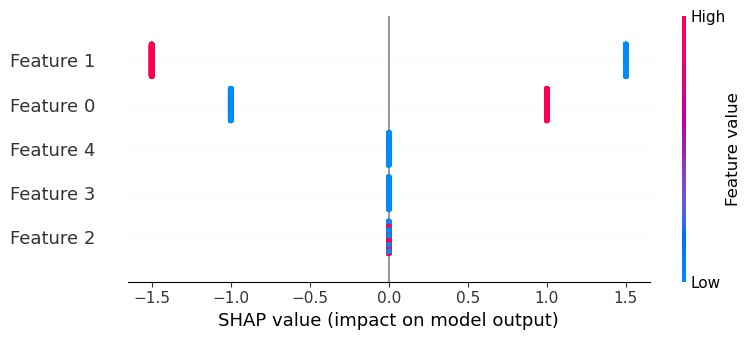

In [15]:
shap.summary_plot(shap_values, X)